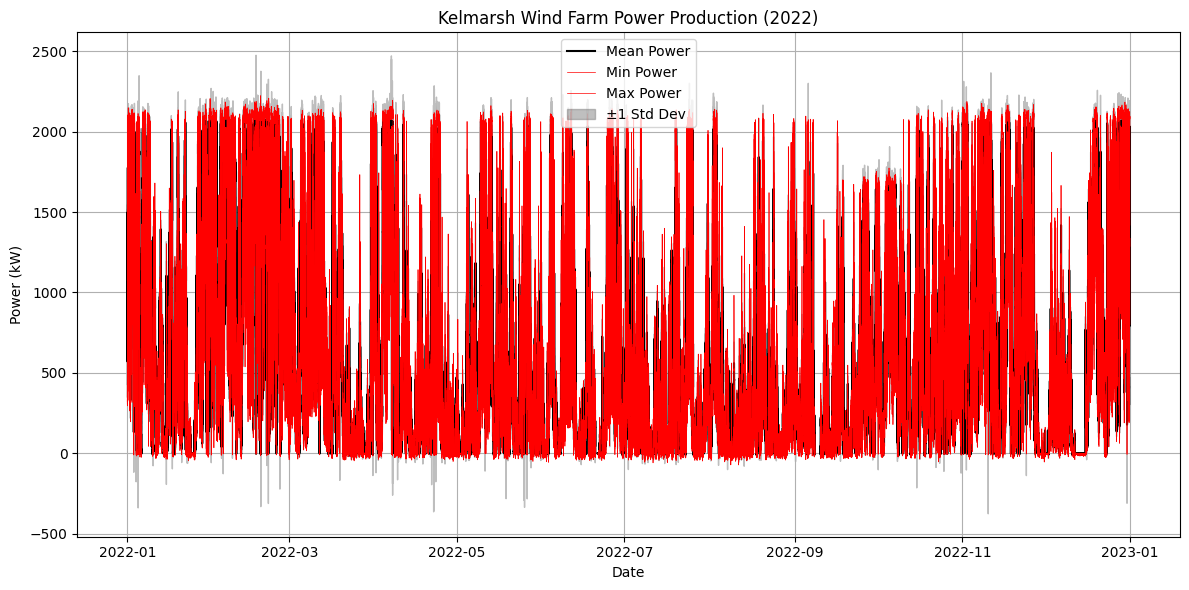

In [15]:
#1. Load and Plot
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv('./km_scada_sample_2022.csv', index_col=0, parse_dates=True)

# Plotting
plt.figure(figsize=(12, 6))

# Mean (black line)
plt.plot(df.index, df['Power (kW)'], color='black', label='Mean Power')

# Min and Max (blue lines)
plt.plot(df.index, df['Power, Minimum (kW)'], color='red',linewidth=0.5,  label='Min Power')
plt.plot(df.index, df['Power, Maximum (kW)'], color='red',linewidth=0.5,  label='Max Power')

# Std deviation (gray shaded area)
plt.fill_between(df.index,
                 df['Power (kW)'] - df['Power, Standard deviation (kW)'],
                 df['Power (kW)'] + df['Power, Standard deviation (kW)'],
                 color='gray', alpha=0.5, label='±1 Std Dev')

# Labels and legend
plt.title('Kelmarsh Wind Farm Power Production (2022)')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# Split into train/valid/test - consequective, 9 months, 2 months 1 month, 
# segment for windowed predictions - create windows of window_length = 36, steps ahead = 1
import numpy as np

# Get start date
start_date = df.index.min()

# Create split points dynamically
train_end = start_date + pd.DateOffset(months=9)
valid_end = train_end + pd.DateOffset(months=2)

# Split the data
train = df.loc[start_date:train_end - pd.Timedelta(minutes=10)]
valid = df.loc[train_end:valid_end - pd.Timedelta(minutes=10)]
test  = df.loc[valid_end:]

# Step 2: Extract the target series (e.g., mean power only)
train_series = train['Power (kW)'].values
valid_series = valid['Power (kW)'].values
test_series  = test['Power (kW)'].values

# Step 3: Function to create windowed sequences
def create_windows(series, window_size=18, step_ahead=1):
    X, y = [], []
    for i in range(len(series) - window_size - step_ahead + 1):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size + step_ahead - 1])
    return np.array(X), np.array(y)

# Create windowed datasets
X_train, y_train = create_windows(train_series)
X_valid, y_valid = create_windows(valid_series)
X_test, y_test = create_windows(test_series)

# Output shapes for sanity check
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Valid shape: {X_valid.shape}, {y_valid.shape}")
print(f"Test shape:  {X_test.shape}, {y_test.shape}")

# Convert numpy arrays to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # shape: (samples, 36, 1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)  # shape: (samples, 1)
X_valid_t = torch.tensor(X_valid, dtype=torch.float32).unsqueeze(-1)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(-1)


Train shape: (39294, 18), (39294,)
Valid shape: (8766, 18), (8766,)
Test shape:  (4446, 18), (4446,)


In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from itertools import product
from tqdm import tqdm

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # x: (batch, seq_len, input_size)
        out = self.linear(lstm_out[:, -1, :])  # take output at final time step
        return out
        
def train_and_eval_model(hp, X_train_t, y_train_t, X_valid_t, y_valid_t, num_epochs):
    # Unpack hyperparameters
    hidden_size = hp['hidden_size']
    num_layers = hp['num_layers']
    lr = hp['lr']
    batch_size = hp['batch_size']

    # Model, loss, optimizer
    model = LSTMPredictor(hidden_size=hidden_size, num_layers=num_layers)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Dataloaders
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(TensorDataset(X_valid_t, y_valid_t), batch_size=batch_size)

    # Training loop
    model.train()
    for epoch in tqdm(range(num_epochs)):  # Keep short for tuning; increase later if needed
        for X_batch, y_batch in train_loader:
            # Skip batch if any NaNs are present
            if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
                continue
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation loss
    model.eval()
    total_loss = 0
    n_batches = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
                continue
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            total_loss += loss.item()
            n_batches += 1

    val_loss = total_loss / n_batches if n_batches > 0 else float('inf')

    return val_loss, model, hp
    
# Hyperparameter grid
param_grid = {
    'hidden_size': [8],                #'hidden_size': [8, 16],
    'num_layers': [2],                 #'num_layers': [1, 2],
    'lr': [0.01],                      #'lr': [0.001, 0.01],
    'batch_size': [64]                 #'batch_size': [32, 64]
}
num_epochs = 200

# All combinations
grid = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

best_loss = float('inf')
best_model = None
best_hps = None

for hparams in grid:
    hps = dict(zip(param_names, hparams))
    val_loss, model, used_hps = train_and_eval_model(hps, X_train_t, y_train_t, X_valid_t, y_valid_t, num_epochs)

    print(f"Tested {used_hps}, Validation Loss: {val_loss:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_hps = used_hps

print("\nBest Hyperparameters:")
print(best_hps)
print(f"Validation Loss: {best_loss:.4f}")



100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:17<00:00,  1.29s/it]


Tested {'hidden_size': 8, 'num_layers': 2, 'lr': 0.01, 'batch_size': 64}, Validation Loss: 157203.7825

Best Hyperparameters:
{'hidden_size': 8, 'num_layers': 2, 'lr': 0.01, 'batch_size': 64}
Validation Loss: 157203.7825


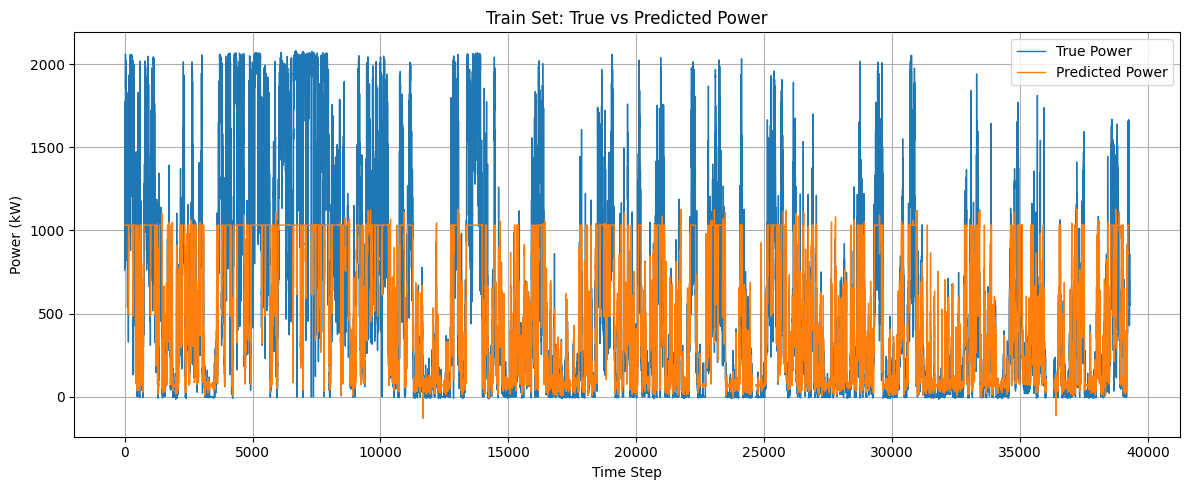

In [39]:
import matplotlib.pyplot as plt

def plot_predictions(model, X, y, split_name='valid'):
    """
    Plot true vs predicted values for a given split.
    
    Args:
        model: Trained PyTorch model
        X: Input sequences (numpy array or torch tensor)
        y: Ground truth values (numpy array or torch tensor)
        split_name: One of 'train', 'valid', 'test'
        max_points: Optional int to limit plot length for readability
    """
    model.eval()
    
    # Convert to tensor if not already
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

    with torch.no_grad():
        y_pred_t = model(X)
    
    # Convert to numpy
    y_pred = y_pred_t.squeeze().numpy()
    y_true = y.squeeze().numpy()

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='True Power', linewidth=1)
    plt.plot(y_pred, label='Predicted Power', linewidth=1)
    plt.title(f'{split_name.capitalize()} Set: True vs Predicted Power')
    plt.xlabel('Time Step')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



split = "train"  # or "train" or "valid"

if split == "train":
    plot_predictions(best_model, X_train, y_train, split_name='train')
elif split == "valid":
    plot_predictions(best_model, X_valid, y_valid, split_name='valid')
elif split == "test":
    plot_predictions(best_model, X_test, y_test, split_name='test')
else:
    print("Invalid split name. Choose from 'train', 'valid', 'test'.")
